In [1]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision
import random
import numpy as np
import cv2
import torch
import torchvision
import random
import cv2
import requests
import zipfile
import os
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

ModuleNotFoundError: No module named 'torch'

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
def apply_filter(dataset, randomize=False):
    # Create a list to hold the filtered images
    filtered_dataset = []
    convert_tensor = transforms.ToTensor()

    # Generate a random 3x3 kernel if randomization is enabled
    kernel = None
    if randomize:
        kernel = np.random.rand(3, 3)

    for image, label in dataset:
        # Convert the image to grayscale
        fimage = convert_tensor(image).permute(1, 2, 0).numpy()  # Convert the image tensor to a NumPy array
        fimage = cv2.cvtColor(fimage, cv2.COLOR_RGB2GRAY)  # Grayscale image
        
        # Apply the filter
        if randomize:
            fimage = cv2.filter2D(fimage, -1, kernel)
        else:
            fimage = cv2.GaussianBlur(fimage,(3,3), 0, 0) 
            fimage = cv2.Sobel(fimage, cv2.CV_64F, dx=1, dy=1, ksize=3)  # Sobel filter
        
        # Convert the filtered image back to a tensor
        fimage = torch.tensor(fimage, dtype=torch.float).unsqueeze(0)
        filtered_dataset.append((convert_tensor(image), fimage))
    
    return filtered_dataset

In [ ]:
def preview_filtered_dataset(train_dataset, num_images=5, save_plot=False):
    # Select a few random images from the training dataset
    indices = random.sample(range(len(train_dataset)), num_images)
    images = [train_dataset[i][0] for i in indices]
    filtered_images = [train_dataset[i][1] for i in indices]

    # Plot the images
    fig, ax = plt.subplots(num_images, 2, figsize=(5, 15))
    for i, (image, filtered_image) in enumerate(zip(images, filtered_images)):
        ax[i][0].imshow(image.permute(1, 2, 0).squeeze())
        ax[i][0].axis('off')
        ax[i][1].imshow(filtered_image.squeeze(), cmap='gray')
        ax[i][1].axis('off')
    
    if save_plot:
        plt.savefig('preview_plot.png')
    else:
        plt.show()

In [ ]:
def preview_predictions(model, val_dataset, num_images=4, save_plot=False, plot_save_path=None):
    """
    Shows a preview of the model's predictions on the validation dataset. The input, output, and target images
    are plotted for a given number of images. The images are taken from the beginning of the validation dataset.
    
    Parameters:
        model (torch.nn.Module): The model to use for prediction.
        val_dataset (torch.utils.data.Dataset): The validation dataset to use for prediction.
        num_images (int, optional): The number of images to show in the preview. Default is 4.
        save_plot (bool, optional): Flag to indicate whether to save the plot. Default is False.
        plot_save_path (str, optional): The file path to save the plot to. Only used if save_plot is True.
            Default is None.
    """
    # Create a data iterator for the validation dataset
    val_iterator = torch.utils.data.DataLoader(val_dataset, batch_size=num_images, shuffle=False)
    
    # Get a batch of images from the val dataset
    input_images, target_images = next(iter(val_iterator))

    # Use the model to predict the output images
    output_images = model(input_images)

    # Detach the images from the computational graph to prevent a ValueError
    input_images = input_images.detach().numpy()
    output_images = output_images.detach().numpy()
    target_images = target_images.detach().numpy()

    # Create the figure and subplots
    fig, axs = plt.subplots(nrows=num_images, ncols=3, figsize=(9, num_images*4))

    # Plot the input, output, and target images for each image in the batch
    for i in range(num_images):
        axs[i, 0].imshow(input_images[i, 0, :, :], cmap="gray", vmin=0, vmax=1)
        axs[i, 0].set_title("Input")
        axs[i, 1].imshow(output_images[i, 0, :, :], cmap="gray")
        axs[i, 1].set_title("Model Output")
        axs[i, 2].imshow(target_images[i, 0, :, :], cmap="gray")
        axs[i, 2].set_title("Target")

    # Remove the axes labels and tick marks
    for ax in axs.flat:
        ax.set_axis_off()

    # Show the figure
    plt.show()
    
    # Save the plot if specified
    if save_plot:
        fig.savefig(plot_save_path)




In [ ]:
def load_filtered_dataset(randomize=False):
    # Check if the data has already been downloaded
    if not os.path.exists("./data/tiny-imagenet-200"):
        # Download the TinyImageNet dataset
        url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
        response = requests.get(url, stream=True)

        with open("tiny-imagenet-200.zip", "wb") as f:
            f.write(response.content)

        # Extract the contents of the zip file
        with zipfile.ZipFile("tiny-imagenet-200.zip", "r") as zip_ref:
            zip_ref.extractall("./data")

    # Load the TinyImageNet dataset
    dataset = torchvision.datasets.ImageFolder(root='./data/tiny-imagenet-200/train', transform=None)

    # Apply the filter to the dataset
    filtered_dataset = apply_filter(dataset, randomize=randomize)

    # Split the filtered dataset into a training set and a validation set
    random.shuffle(filtered_dataset)
    split_index = int(0.8 * len(filtered_dataset))
    train_dataset = filtered_dataset[:split_index]
    val_dataset = filtered_dataset[split_index:]
    
    return train_dataset, val_dataset

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_losses(training_losses, validation_losses, save=False,trunc=0):
  # Set the seaborn style
  sns.set()

  # Create a high resolution figure
  plt.figure(figsize=(12, 8))


  # Plot the average of the loss
  plt.plot(training_losses[trunc:], label="Train Loss", linewidth=3, color='red')


  # # Plot the average of the loss
  plt.plot(validation_losses[trunc:], label="Validation Loss", linewidth=3, color='blue')

  # Add a legend
  plt.legend(loc="upper right", fontsize=20)

  # Set the x-axis and y-axis labels
  plt.xlabel("Iteration", fontsize=20)
  plt.ylabel("Loss", fontsize=20)

  # Set the title
  plt.title("Loss as training progresses", fontsize=24)

  # Set the font size of the tick labels
  plt.tick_params(labelsize=20)

  if save:
    # Save the figure to a file
    plt.savefig("training_loss.png", dpi=300)

  # Show the figure
  plt.show()


In [ ]:
train_dataset, val_dataset = load_filtered_dataset(randomize=False)

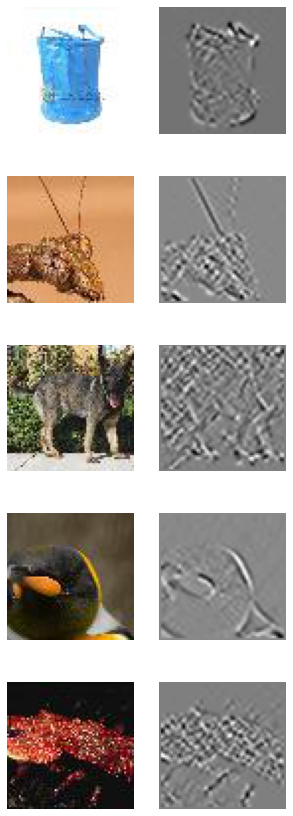

In [ ]:
preview_filtered_dataset(train_dataset)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt



In [ ]:

# Define an img2img network
class Img2ImgNetwork(nn.Module):
    def __init__(self, num_input_channels, num_output_channels):
        super(Img2ImgNetwork, self).__init__()
        self.conv1 = nn.Conv2d(num_input_channels, num_output_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(num_output_channels, num_output_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(num_output_channels, num_output_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.conv3(x)
        return x


num_input_channels = 3  # RGB color image
num_output_channels = 1  # Filtered image
model = Img2ImgNetwork(num_input_channels, num_output_channels)



In [ ]:

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

48


In [ ]:

def train_model(model, 
                train_dataset,
                val_dataset,
                max_epochs=100, 
                early_stopping_patience=5,
                batch_size=128,
                learning_rate=0.001,
                save_best=False,
                save_path=None):
    """
    Trains the model on the training dataset and validates it on the validation dataset.
    The model is trained using the Adam optimizer and the L1 loss function. The learning rate
    is scheduled using the CosineAnnealingLR scheduler. Early stopping is used to prevent overfitting.
    
    Parameters:
        model (torch.nn.Module): The model to be trained.
        train_dataset (torch.utils.data.Dataset): The training dataset.
        val_dataset (torch.utils.data.Dataset): The validation dataset.
        max_epochs (int, optional): The maximum number of epochs to train for. Default is 100.
        early_stopping_patience (int, optional): The number of epochs to wait before stopping
            training if the validation loss does not improve. Default is 5.
        batch_size (int, optional): The batch size to use for training and validation. Default is 128.
        learning_rate (float, optional): The initial learning rate for the Adam optimizer. Default is 0.001.
        save_best (bool, optional): Flag to indicate whether to save the model with the best validation loss.
            Default is False.
        save_path (str, optional): The file path to save the model to. Only used if save_best is True.
            Default is None.
            
    Returns:
        tuple: A tuple containing the lists of training losses and validation losses at each epoch.
    """

    # Create a data iterator for the training dataset
    train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_iterator = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)


    loss_fn = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize the early stopping counter
    early_stopping_counter = 0

    # Initialize the best validation loss
    best_val_loss = float("inf")

    # Keep track of the loss and other metrics during training
    losses = []
    validation_losses = []


    # Initialize the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

    # Loop over the epochs
    for epoch in range(max_epochs):
        # Set the model to training mode
        model.train()
        
        # Initialize the epoch loss
        epoch_loss = 0.0
        
        # Loop over the training batches
        for input_images, target_images in train_iterator:
            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass through the model
            output_images = model(input_images)
            
            # Compute the loss
            loss = loss_fn(output_images, target_images)
            
            # Backward pass through the model
            loss.backward()
            
            # Update the model parameters
            optimizer.step()
            
            # Accumulate the epoch loss
            epoch_loss += loss.item()
        
        # Set the model to evaluation mode
        model.eval()
        
        # Initialize the validation loss
        val_loss = 0.0
        
        # Loop over the validation batches
        for input_images, target_images in val_iterator:
            # Forward pass through the model
            output_images = model(input_images)
            
            # Compute the loss
            loss = loss_fn(output_images, target_images)
            
            # Accumulate the validation loss
            val_loss += loss.item()
        
        # Compute the average training and validation losses
        avg_train_loss = epoch_loss / len(train_iterator)
        losses.append(avg_train_loss)

        avg_val_loss = val_loss / len(val_iterator)
        validation_losses.append(avg_val_loss)
        
        # Print the epoch loss and validation loss
        print(f"Epoch: {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        
        # Update the learning rate
        scheduler.step()
        
        # Check if the validation loss is the best seen so far
        if avg_val_loss < best_val_loss:
            # Update the best validation loss
            best_val_loss = avg_val_loss
            if save_best:
              torch.save(model.state_dict(), save_path)
            
            # Reset the early stopping counter
            early_stopping_counter = 0
        else:
            # Increment the early stopping counter
            early_stopping_counter += 1
            
        if early_stopping_counter>=early_stopping_patience:
          print('Early Stopping')
          break
    
    return losses, validation_losses


In [ ]:
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

In [ ]:
train_losses, val_losses = train_model(model, 
                                       train_dataset, 
                                       val_dataset, 
                                       max_epochs=50, 
                                       early_stopping_patience=5, 
                                       batch_size=128, 
                                       learning_rate=0.001)

# Save the model with the best validation loss
# torch.save(model.state_dict(), "best_model.pt")

Epoch: 1, Training Loss: 0.0561, Validation Loss: 0.0517
Epoch: 2, Training Loss: 0.0411, Validation Loss: 0.0260
Epoch: 3, Training Loss: 0.0217, Validation Loss: 0.0192
Epoch: 4, Training Loss: 0.0181, Validation Loss: 0.0177
Epoch: 5, Training Loss: 0.0167, Validation Loss: 0.0161
Epoch: 6, Training Loss: 0.0158, Validation Loss: 0.0156
Epoch: 7, Training Loss: 0.0152, Validation Loss: 0.0152
Epoch: 8, Training Loss: 0.0147, Validation Loss: 0.0144
Epoch: 9, Training Loss: 0.0143, Validation Loss: 0.0141
Epoch: 10, Training Loss: 0.0139, Validation Loss: 0.0137
Epoch: 11, Training Loss: 0.0136, Validation Loss: 0.0136
Epoch: 12, Training Loss: 0.0133, Validation Loss: 0.0135
Epoch: 13, Training Loss: 0.0138, Validation Loss: 0.0134
Epoch: 14, Training Loss: 0.0134, Validation Loss: 0.0135
Epoch: 15, Training Loss: 0.0127, Validation Loss: 0.0127
Epoch: 16, Training Loss: 0.0126, Validation Loss: 0.0126
Epoch: 17, Training Loss: 0.0125, Validation Loss: 0.0127
Epoch: 18, Training Los

In [ ]:
plot_losses(train_losses, val_losses, save=True)

NameError: ignored

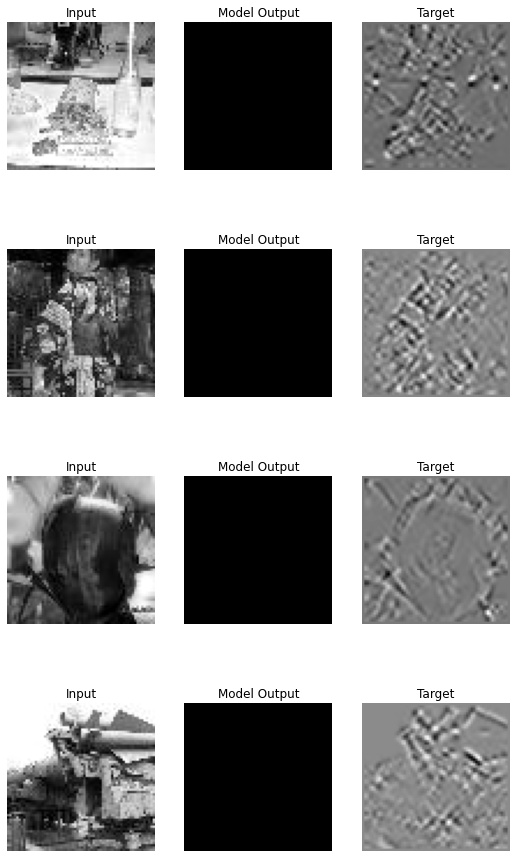

In [ ]:
preview_predictions(model, val_dataset, num_images=4, save_plot=True, plot_save_path="prediction_plot.png")

In [ ]:
import time
# Create a data iterator for the training dataset
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Train the network for one epoch
num_epochs = 1
for epoch in range(num_epochs):
    # Start the timer
    start_time = time.time()
    loss_fn = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Loop over the training data
    for input_images, target_images in train_iterator:
        # Forward pass
        output_images = model(input_images)
        loss = loss_fn(output_images, target_images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # End the timer and print the elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time for epoch {epoch+1}/{num_epochs}: {elapsed_time:.4f} seconds")

Elapsed time for epoch 1/1: 69.4184 seconds


In [ ]:
# Start the timer
start_time = time.time()

# Perform inference on a batch of input images
output_images = model(input_images)

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for inference: {elapsed_time:.4f} seconds")

Elapsed time for inference: 0.0305 seconds


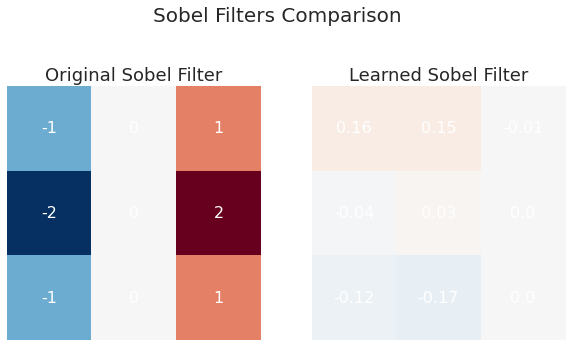

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Define the original Sobel filter
sobel_filter = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])

# Define the learned Sobel filter
learned_filter = model.conv1.weight.detach().numpy()[0, 0, :, :]  # Extract the first channel of the first weight tensor

# Set the figure size and title
plt.figure(figsize=(10, 6))
plt.suptitle("Sobel Filters Comparison", fontsize=20)

# Plot the original Sobel filter
plt.subplot(1, 2, 1)
plt.imshow(sobel_filter, cmap="RdBu_r", vmin=-2, vmax=2)
plt.title("Original Sobel Filter", fontsize=18)
for i in range(3):
    for j in range(3):
        plt.text(j, i, round(sobel_filter[i, j], 2), ha="center", va="center", color="white", fontsize=16)
plt.axis("off")

# Plot the learned Sobel filter
plt.subplot(1, 2, 2)
plt.imshow(learned_filter, cmap="RdBu_r", vmin=-2, vmax=2)
plt.title("Learned Sobel Filter", fontsize=18)
for i in range(3):
    for j in range(3):
        plt.text(j, i, round(learned_filter[i, j], 2), ha="center", va="center", color="white", fontsize=16)
plt.axis("off")

# Show the plot
plt.show()


## Generalising this Model



* If the image is really large or not of a standard size, you can use padding to ensure that the image is of a standard size. Alternatively, you can resize the image to a standard size before feeding it into the model.

* At the edges of the image, you can use padding to ensure that the convolutional filters are applied correctly to the image. This will prevent the loss of any important information at the edges of the image.
* The runtime performance of training and inference will depend on the size and complexity of the model, as well as the hardware being used. Using a GPU can significantly improve the performance of both training and inference. There are also many optimization techniques that can be applied to improve performance, such as using more efficient convolutional layers and reducing the number of parameters in the model.
* This model does not use a fully connected network. It uses convolutional layers to process the input image.
* PyTorch and other deep learning frameworks have built-in optimization techniques that can improve the performance of the model. For example, PyTorch uses automatic differentiation to compute gradients during backpropagation, which can be more efficient than manually computing gradients.
* Inference can be made faster by using a smaller and simpler model, as well as using hardware acceleration such as a GPU. It can also be made faster by optimizing the model's forward pass and reducing the number of operations that need to be performed.
* Training is typically considered complete when the loss on the validation set stops decreasing or starts to increase. This indicates that the model is no longer improving and that it has reached its maximum performance.
* The Sobel kernel size can be specified in the model by setting the kernel size parameter in the Conv2d layers. For example, in the current model, the kernel size is set to 3x3.

In [ ]:
train_dataset, val_dataset = load_filtered_dataset(randomize=True)

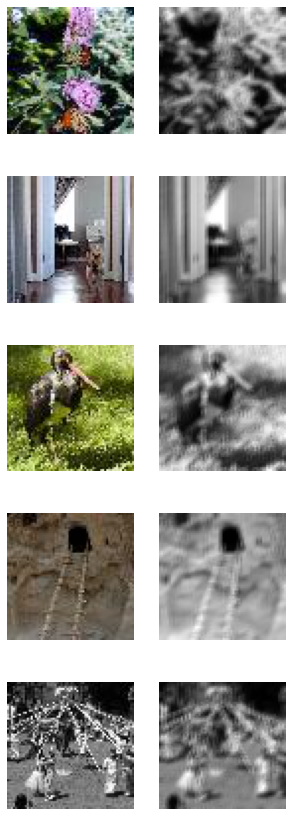

In [ ]:
preview_filtered_dataset(train_dataset)

In [ ]:

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

48


In [ ]:
train_losses, val_losses = train_model(model, 
                                       train_dataset, 
                                       val_dataset, 
                                       max_epochs=50, 
                                       early_stopping_patience=5, 
                                       batch_size=128, 
                                       learning_rate=0.005)


Epoch: 1, Training Loss: 0.8983, Validation Loss: 0.8994
Epoch: 2, Training Loss: 0.8983, Validation Loss: 0.8995
Epoch: 3, Training Loss: 0.8984, Validation Loss: 0.8993
Epoch: 4, Training Loss: 0.8983, Validation Loss: 0.8993
Epoch: 5, Training Loss: 0.8984, Validation Loss: 0.8993
Epoch: 6, Training Loss: 0.8983, Validation Loss: 0.8993
Epoch: 7, Training Loss: 0.8983, Validation Loss: 0.8993
Epoch: 8, Training Loss: 0.8983, Validation Loss: 0.8994
Epoch: 9, Training Loss: 0.8983, Validation Loss: 0.8994
Early Stopping


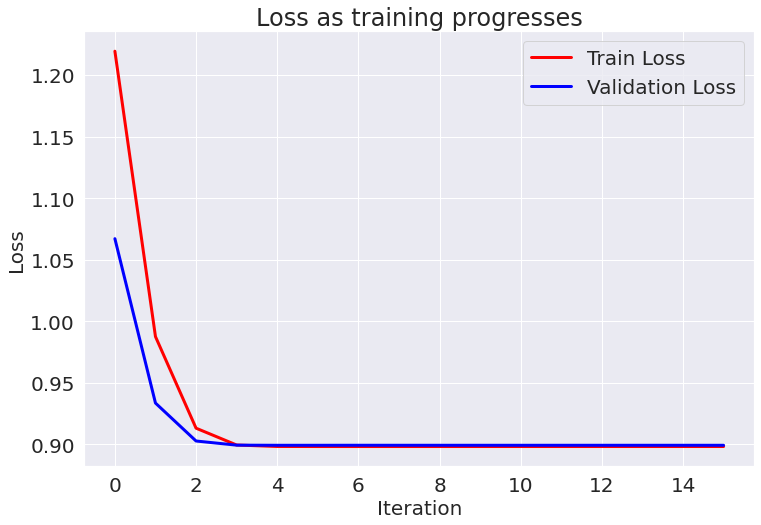

In [ ]:
plot_losses(train_losses, val_losses, save=True)

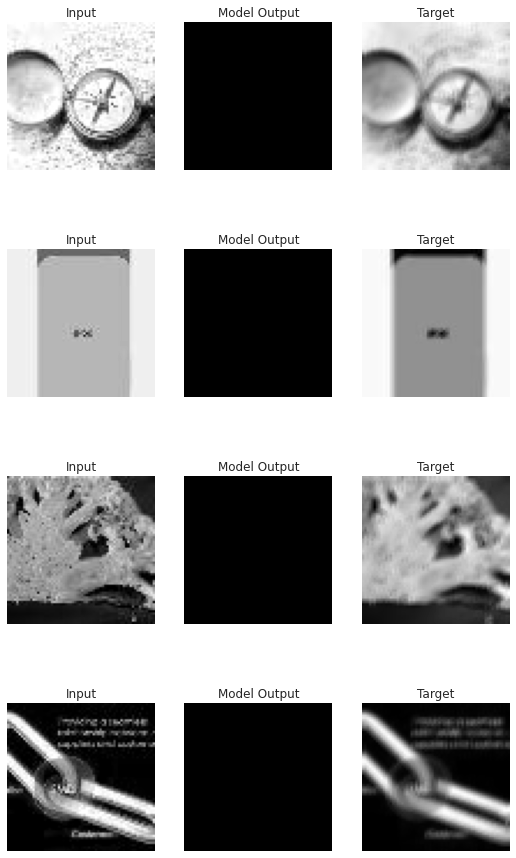

In [ ]:
preview_predictions(model, val_dataset, num_images=4, save_plot=True, plot_save_path="prediction_plot.png")